# Import necessary packages

In [1]:
from dtw import *
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import importlib
np.int = np.int32
import networkx as nx

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



# Load single cell data

In [2]:
data = pd.read_csv("temporal_data_ready_normalized.csv", index_col=0)
# remove rows with NaN values
data = data.dropna(axis=0)

data

,d0,d1,d2,d5,d9,d15
gene_cell_type,,,,,,
A2M_B_cells,-0.254104,-0.230321,-0.280389,-0.263553,-0.251973,-0.011464
A2M_CD4_memory_T,0.060641,0.008146,-0.137329,-0.088526,-0.135368,-0.229559
A2M_CD4_memory_activated_T,-0.164474,-0.183414,-0.299799,-0.244234,-0.245678,-0.226539
A2M_CD4_naive_T,-0.212623,-0.236981,-0.299799,-0.192497,-0.299799,0.175611
A2M_CD8_naive_T,-0.233574,-0.238156,-0.299799,-0.299799,-0.299799,-0.299799
...,...,...,...,...,...,...
ZWINT_CIK_cells,-0.423474,-0.352725,-0.480251,-0.303389,-0.320375,-0.382367
ZWINT_Cycling_CD8_T,1.166380,0.331294,1.573891,0.908543,0.989413,0.899322
ZWINT_Cycling_CD8_memory_activated_T,1.427874,1.080232,2.436266,0.980481,1.059959,1.132355


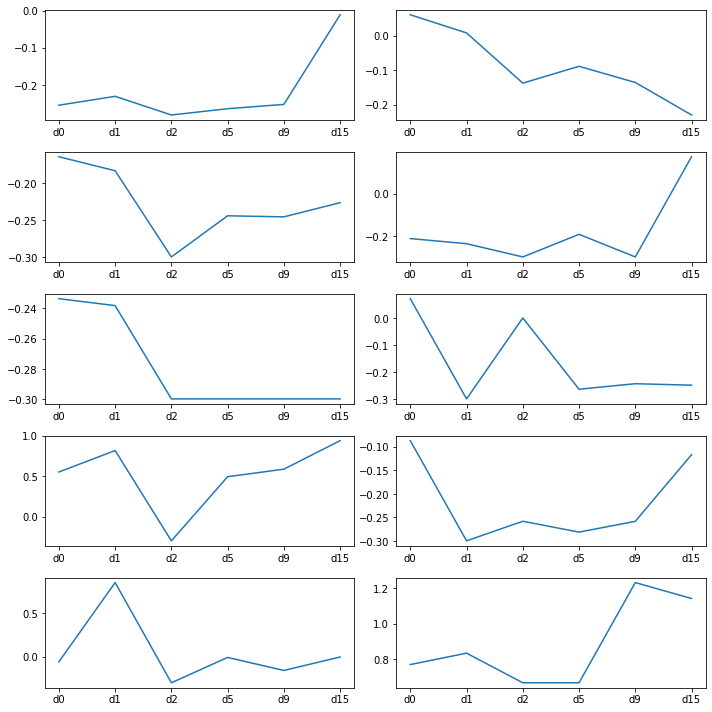

In [3]:
# plot the first 10 time series
fig, ax = plt.subplots(5, 2, figsize=(10, 10))
for i in range(5):
    for j in range(2):
        data.iloc[i*2+j].plot(ax=ax[i, j])
plt.tight_layout()
plt.show()


In [4]:
index_names = data.index
index_names

Index(['A2M_B_cells', 'A2M_CD4_memory_T', 'A2M_CD4_memory_activated_T',
       'A2M_CD4_naive_T', 'A2M_CD8_naive_T', 'A2M_CD8_naive_activated_T',
       'A2M_CIK_cells', 'A2M_Cycling_CD8_T',
       'A2M_Cycling_CD8_memory_activated_T', 'A2M_NK1',
       ...
       'ZWINT_CD4_memory_T', 'ZWINT_CD4_memory_activated_T',
       'ZWINT_CD4_naive_T', 'ZWINT_CD8_naive_T', 'ZWINT_CD8_naive_activated_T',
       'ZWINT_CIK_cells', 'ZWINT_Cycling_CD8_T',
       'ZWINT_Cycling_CD8_memory_activated_T', 'ZWINT_NK1',
       'ZWINT_γδ_T_cells'],
      dtype='object', name='gene_cell_type', length=22000)

In [5]:
filter_thresh = 4999

if filter_thresh is not None:
  array_2d = data.iloc[:filter_thresh, ].to_numpy()
else:
  array_2d = data.to_numpy()

array_2d

array([[-0.25410362, -0.23032057, -0.28038883, -0.26355267, -0.25197296,
        -0.01146419],
       [ 0.06064104,  0.00814554, -0.1373292 , -0.0885261 , -0.13536754,
        -0.22955916],
       [-0.16447384, -0.18341367, -0.29979874, -0.24423447, -0.24567763,
        -0.22653949],
       ...,
       [-0.05853819, -0.05853819, -0.05853819,  0.01345254, -0.04451731,
        -0.0486575 ],
       [-0.05262372, -0.04221822, -0.05853819, -0.05853819, -0.05853819,
        -0.05853819],
       [-0.05853819, -0.03283932, -0.05853819, -0.05853819, -0.05853819,
        -0.05853819]])

## Filtro di dtw basato su reactome PPI

In [6]:
PPI_graph = pd.read_table('FIsInGene_122921_with_annotations.txt')
G = nx.from_pandas_edgelist(PPI_graph, 'Gene1', 'Gene2', 'Score')

In [35]:
# for loop between all time series, calculate the distance between each pair
# and append the distance to a csv file

# create result dataframe with colnames 'index1', 'index2', 'distance'
distance_df = pd.DataFrame(columns=['index1', 'index2', 'distance'])

gene_names = [x.split('_')[0] for x in index_names]
for i in range(len(array_2d)):
  for j in range(i + 1, len(array_2d)):  # Start j from i+1 to avoid duplicate pairs

    if G.has_edge(gene_names[i], gene_names[j]):
      alignment = dtw(array_2d[i], array_2d[j], keep_internals=True)
      # append the distance to the result dataframe
      distance_df = pd.concat([distance_df, pd.DataFrame([{'index1': index_names[i], 'index2': index_names[j], 'distance': alignment.distance}])], ignore_index=True)
    else:
      # skip the pair if there is no edge between the two genes in the PPI network
      continue

    # print the progress of the loop
    if j % 10 == 0:
      print("Progress: ", i, j)


Progress:  0 2350
Progress:  0 2590
Progress:  1 2350
Progress:  1 2590
Progress:  2 2350
Progress:  2 2590
Progress:  3 2350
Progress:  3 2590
Progress:  4 2350
Progress:  4 2590
Progress:  5 2350
Progress:  5 2590
Progress:  6 2350
Progress:  6 2590
Progress:  7 2350
Progress:  7 2590
Progress:  8 2350
Progress:  8 2590
Progress:  9 2350
Progress:  9 2590
Progress:  10 2350
Progress:  10 2590
Progress:  44 1640
Progress:  44 2590
Progress:  44 2730
Progress:  44 2920
Progress:  44 3470
Progress:  44 3480
Progress:  44 3540
Progress:  44 3730
Progress:  44 4160
Progress:  45 1640
Progress:  45 2590
Progress:  45 2730
Progress:  45 2920
Progress:  45 3470
Progress:  45 3480
Progress:  45 3540
Progress:  45 3730
Progress:  45 4160
Progress:  46 1640
Progress:  46 2590
Progress:  46 2730
Progress:  46 2920
Progress:  46 3470
Progress:  46 3480
Progress:  46 3540
Progress:  46 3730
Progress:  46 4160
Progress:  47 1640
Progress:  47 2590
Progress:  47 2730
Progress:  47 2920
Progress:  47

In [36]:
# remove duplicate rows having the same exact distance
#distance_df = distance_df.drop_duplicates(subset='distance')

# sort distance_df by distance
distance_df = distance_df.sort_values(by='distance', ascending=True)
distance_df

,index1,index2,distance
17054,BUB1_CD8_naive_T,CCNA2_CD8_naive_T,0.006495
11279,AURKB_CD8_naive_T,BUB1B_CD8_naive_T,0.007974
11278,AURKB_CD8_naive_T,BUB1B_CD4_naive_T,0.011451
17053,BUB1_CD8_naive_T,CCNA2_CD4_naive_T,0.016024
17153,BUB1_CD8_naive_T,CENPE_CD8_naive_T,0.027692
...,...,...,...
16148,BTK_CD8_naive_activated_T,CD79A_B_cells,34.921674
34973,CD79A_B_cells,CD79B_CD8_naive_T,35.071202
20493,CALR_CD8_naive_T,CD40_B_cells,35.542244
34979,CD79A_B_cells,CD79B_γδ_T_cells,35.818371


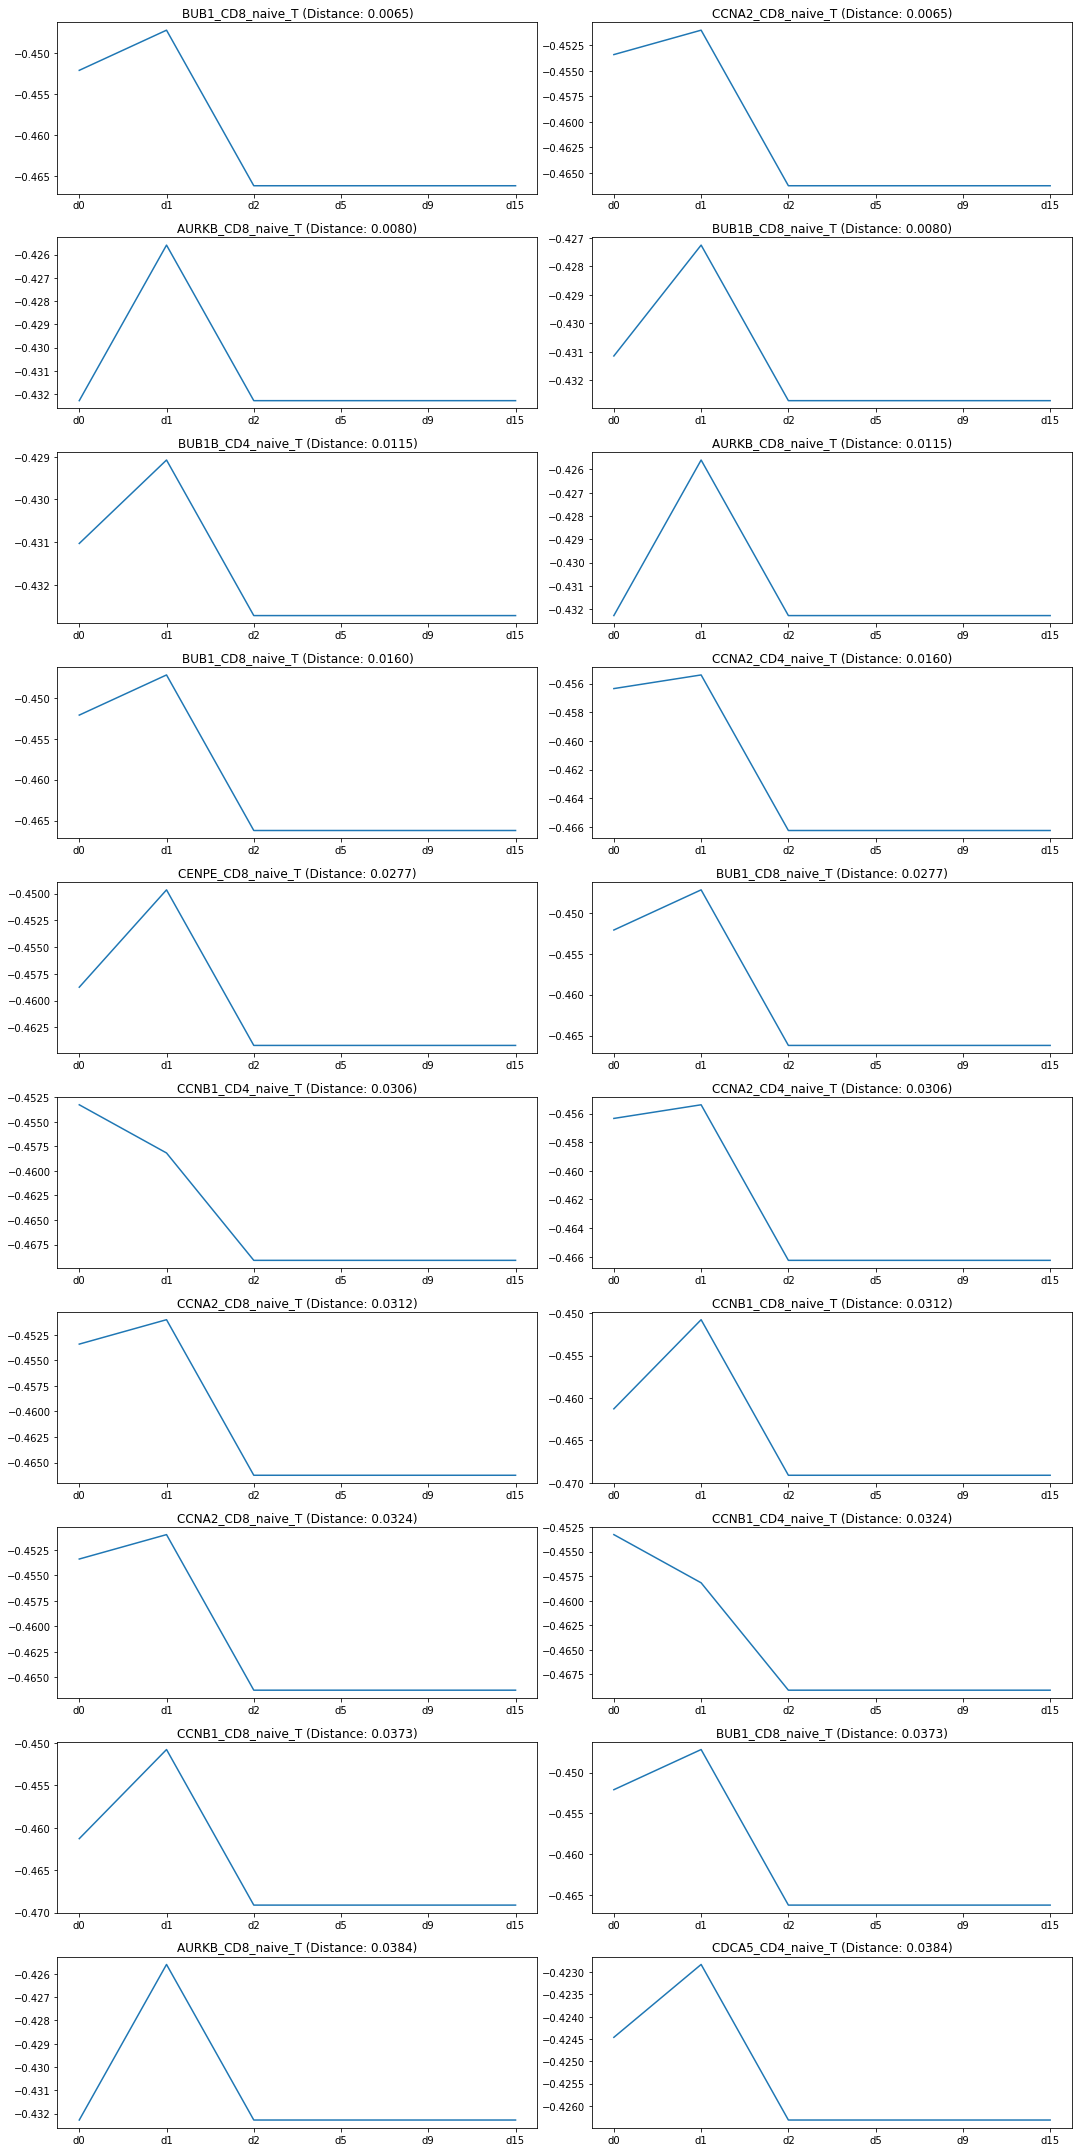

In [33]:
# Get the first 10 correspondences with the smallest distances
top_10_correspondences = distance_df.head(10)

# Plot the time series correspondences
fig, axes = plt.subplots(10, 2, figsize=(15, 30))
for i, (index1, index2, distance) in enumerate(top_10_correspondences.values):
  data.loc[index1].plot(ax=axes[i, 0], title=f'{index1} (Distance: {distance:.4f})')
  data.loc[index2].plot(ax=axes[i, 1], title=f'{index2} (Distance: {distance:.4f})')

plt.tight_layout()
plt.show()

In [34]:
distance_df.to_csv('distance_df.csv', index=False)